In [1]:
#Importing Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import AffinityPropagation
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import metrics
from itertools import cycle

In [2]:
#Vectorize Words
class GloveVectorizer:
  def __init__(self):
    # load in pre-trained word vectors
    print('Loading word vectors...')
    word2vec = {}
    embedding = []
    idx2word = []
    with open('glove.6B.50d.txt',encoding='utf-8', errors='ignore') as f:
      # is just a space-separated text file in the format:
      # word vec[0] vec[1] vec[2] ...
      for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
        embedding.append(vec)
        idx2word.append(word)
    print('Found %s word vectors.' % len(word2vec))

    # save for later
    self.word2vec = word2vec
    self.embedding = np.array(embedding)
    self.word2idx = {v:k for k,v in enumerate(idx2word)}
    self.V, self.D = self.embedding.shape

  def fit(self, data):
    pass

  def transform(self, data):
    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.lower().split()
      vecs = []
      for word in tokens:
        if word in self.word2vec:
          vec = self.word2vec[word]
          vecs.append(vec)
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X

  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

In [3]:
train = pd.read_csv('r52-train-all-terms.txt', header=None, sep='\t')
test = pd.read_csv('r52-test-all-terms.txt', header=None, sep='\t')
train.columns = ['label', 'content']
test.columns = ['label', 'content']
train['lenght'] = train['content'].str.len()
lenght_mn=train['lenght'].mean()
train['lenght_mean']=(lambda x: train['lenght']/lenght_mn)(train['lenght'].values)
train['words_num'] = train['content'].str.split().str.len()
train['words_len_med'] = train['content'].str.len()/train['words_num']
train['words_num_norm'] = (train['words_num'] - train['words_num'].min())/(train['words_num'].max()-train['words_num'].min())
train['words_len_med_norm'] = (train['words_len_med'] - train['words_len_med'].min())/(train['words_len_med'].max()-train['words_len_med'].min())
train['lenght_norm'] = (train['lenght'] - train['lenght'].min())/(train['lenght'].max()-train['lenght'].min())
train['words_num_norm'] = (train['words_num'] - train['words_num'].min())/(train['words_num'].max()-train['words_num'].min())
train['words_len_med_norm'] = (train['words_len_med'] - train['words_len_med'].min())/(train['words_len_med'].max()-train['words_len_med'].min())

In [4]:
#Vectorizer variable
print(train.head())
vectorizer = GloveVectorizer()
Xtrain = vectorizer.fit_transform(train.content)

   label                                            content  lenght  \
0  cocoa  bahia cocoa review showers continued throughou...    2519   
1   earn  champion products ch approves stock split cham...     361   
2    acq  computer terminal systems cpml completes sale ...    1246   
3   earn  cobanco inc cbco year net shr cts vs dlrs net ...     221   
4   earn  am international inc am nd qtr jan oper shr lo...     465   

   lenght_mean  words_num  words_len_med  words_num_norm  words_len_med_norm  \
0     3.881040        456       5.524123        0.436170            0.381910   
1     0.556195         62       5.822581        0.055126            0.438223   
2     1.919721        210       5.933333        0.198259            0.459119   
3     0.340496         44       5.022727        0.037718            0.287307   
4     0.716429         93       5.000000        0.085106            0.283019   

   lenght_norm  
0     0.408971  
1     0.054387  
2     0.199803  
3     0.031384  
4     0

Silhouette Coefficient: -0.587


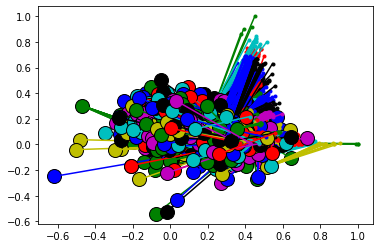

In [6]:
#Fitting X using affinity Propagation Clustering
zipped_data = np.array(list(zip(train.words_len_med_norm, train.lenght_norm)))
afprop = AffinityPropagation(max_iter=1000)
afprop.fit(zipped_data )
labels = afprop.labels_
cluster_centers_indices = afprop.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
# Predict the cluster for all the samples
P = afprop.predict(zipped_data)

# Generate scatter plot for training data
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(Xtrain, labels, metric='sqeuclidean'))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(figsize=(10, 10))
plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = Xtrain[cluster_centers_indices[k]]
    plt.plot(zipped_data[class_members, 0], zipped_data[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in zipped_data[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)
      
